In [1]:
from utils.dataloader import *
from utils.processing import *
from utils.helper import *
from utils.features import *
from utils.classifier import *
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [2]:
RANDOM_STATE = 66
ROOT_PATH, DATA_PATH, OUT_PATH = get_paths()
print(ROOT_PATH)

/Users/moooooo16/Documents/Computer Vision/Project/elpv


In [3]:
img_path, prob, types, labels= load_data(DATA_PATH)

print(len(img_path), 
      len(prob),
      len(types),
      len(labels))

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]
2624 2624 2624 2624


In [17]:
def create_SE():
    l = 13
    se45 = np.zeros((l, l), dtype=np.uint8)
    for i in range(l):
        se45[i, l-i-1] = 1
    
    se135 = np.rot90(se45.copy(), 1)
    
    se90 = np.zeros((l, l), dtype=np.uint8)
    for i in range(l):
        se90[i, l//2] = 1
    
    return se45, se90, se135

def morph_smoothing(img, ses):
    m, n = ses[0].shape
    padding = np.pad(img, m//2, mode='constant', constant_values=0)
    y, x = padding.shape
    new_image = np.zeros(img.shape)
    
    for i in range(y-m+1):
        for j in range(x-n+1):
            
            max_pixle = []
            min_gray_level = []
            for se in ses:
                gray_level = np.sum(padding[i:i+m, j:j+n] * se)
                local_maximum = np.max(padding[i:i+m, j:j+n] * se)
                max_pixle.append(local_maximum)
                min_gray_level.append(gray_level)
                
            new_image[i, j] = max_pixle[np.argmin(min_gray_level)]
            
    return new_image
                

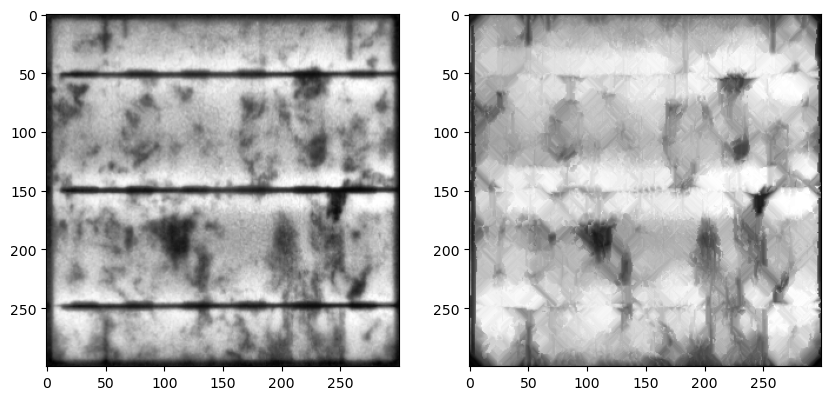

In [23]:
img = cv.imread(os.path.join(DATA_PATH, img_path[1999]), 0)
img = clach_img(img,  clipLimit= 2.0, tileGridSize= (8, 8))
ses = create_SE()
out = morph_smoothing(img, ses)
compar_img(img, out, None)

In [12]:
def convole_sum(img, se):

   m, n = se.shape
   padding = np.pad(img, m//2, mode='constant', constant_values=0)

   y, x = padding.shape

   new_image = np.zeros((y - m + 1, x - n + 1))
   
   for i in range(y-m+1):
      for j in range(x-m + 1):
         # print(i, i + m , j, j + m)
         sm =  np.sum(padding[i:i+m, j:j+m]*se)
            
         new_image[i, j] = sm
            
   return new_image

def morph_smoothing(img, ses):
    
    out = img.copy()
    
    minimum_se = None
    minimum_sum = float('inf')
    all_ses = []
    for se in ses:
        img_sum = convole_sum(img, se)
        all_ses.append(img_sum)

    all_ses = np.array(all_ses)
    print(all_ses.shape)
    dilated = cv.dilate(out, minimum_se)
    
    return dilated, all_ses

def create_SE():
    l = 13
    se45 = np.zeros((l, l), dtype=np.uint8)
    for i in range(l):
        se45[i, l-i-1] = 1
    
    se135 = np.rot90(se45.copy(), 1)
    
    se90 = np.zeros((l, l), dtype=np.uint8)
    for i in range(l):
        se90[i, l//2] = 1
    
    return se45, se90, se135

In [21]:
img = cv.imread(os.path.join(DATA_PATH, img_path[1843]), 0)
ses = create_SE()
out, all_ses = morph_smoothing(img, ses)
compar_img(img, out, None)

ValueError: too many values to unpack (expected 2)

In [11]:
all_ses

array([43261652., 43626789., 43262211.])

In [ ]:
defecet_list = []
nondefect_list = []
num_indices = 15
for label in range(8):

    indices_for_label = np.where(np.array(labels) == label)[0]
    selected_indices = np.random.choice(indices_for_label, num_indices, replace=False)
    if label == 0 or label == 4:
        nondefect_list.extend(selected_indices)
    else:
        defecet_list.extend(selected_indices)
    
len(
nondefect_list), len(defecet_list)

In [ ]:

X = np.array([cv.imread(os.path.join(DATA_PATH, img_path[i]), 0).flatten() for i in nondefect_list])
X.shape

In [ ]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=30, random_state=RANDOM_STATE, whiten='arbitrary-variance', max_iter=500, tol=1e-4)
W = ica.fit_transform(X)
basic_images = ica.components_
basic_images.shape

In [ ]:
test_imag = cv.imread(os.path.join(DATA_PATH, img_path[99]), 0)
print(labels[99])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

U_plus = np.linalg.pinv(basic_images)
b = np.dot(test_imag.flatten(), U_plus)

In [ ]:
similiarity_list = []
for u in basic_images:
    bi = np.dot(u, U_plus)
    similarity = cosine_similarity(b.reshape(1, -1), bi.reshape(1, -1))
    similiarity_list.append(1-similarity)
    print(1- similarity)
    
print(np.argmin(similiarity_list))

In [ ]:
nondefect_list[5]

In [ ]:
compar_img(cv.imread(os.path.join(DATA_PATH, img_path[nondefect_list[5]])), basic_images[5].reshape(300, 300), None)

In [ ]:
y_hat = np.dot(b, basic_images)

In [ ]:
c = np.linalg.norm(y_hat)/np.linalg.norm(test_imag.flatten())

In [ ]:
error = np.linalg.norm(test_imag.flatten() - c * y_hat)

In [ ]:
error